# Import module

In [14]:
from luh2mod import PrepDataSet, ImportData, SetMaskLUH2, SetMaskSurfData, RegridConservative

In [15]:
import matplotlib.pyplot as plt
# import xarray as xr
# import numpy as np
# import xesmf as xe

# Import and Prep Data

In [152]:
state_fn = "/home/glemieux/Data/luh2/states_modified.nc"
static_fn = "/home/glemieux/Data/luh2/staticData_quarterdeg.nc"
surf_fn = "/home/glemieux/Data/luh2/orig/surfdata_4x5_16pfts_Irrig_CMIP6_simyr2000_c170824.nc"

In [17]:
ds_luh2 = PrepDataSet(state_fn)
ds_regrid_target = PrepDataSet(surf_fn)
ds_luh2_static = ImportData(static_fn)

Input file dataset opened: /home/glemieux/Data/luh2/states_modified.nc
LUH2
PrepDataSet: LUH2
LUH2 dataset lat/lon boundary variables formatted and added as new variable for xESMF
data set updated for xESMF

Input file dataset opened: /home/glemieux/Data/luh2/orig/surfdata_4x5_16pfts_Irrig_CMIP6_simyr2000_c170824.nc
Surface
PrepDataSet: SurfData
Surface dataset dimensions renamed for xESMF
data set updated for xESMF

Input file dataset opened: /home/glemieux/Data/luh2/staticData_quarterdeg.nc


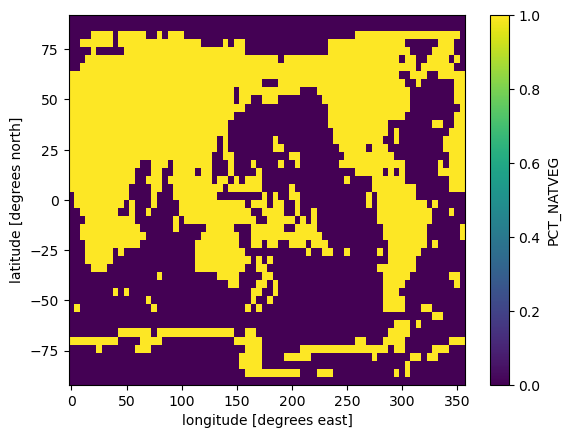

In [213]:
(ds_regrid_target.PCT_NATVEG > 0).plot()

In [209]:
list(ds_regrid_target.variables)

['mxsoil_color',
 'SOIL_COLOR',
 'PCT_SAND',
 'PCT_CLAY',
 'ORGANIC',
 'FMAX',
 'natpft',
 'cft',
 'LANDFRAC_PFT',
 'PFTDATA_MASK',
 'PCT_NATVEG',
 'PCT_CROP',
 'PCT_NAT_PFT',
 'PCT_CFT',
 'MONTHLY_LAI',
 'MONTHLY_SAI',
 'MONTHLY_HEIGHT_TOP',
 'MONTHLY_HEIGHT_BOT',
 'time',
 'AREA',
 'LONGXY',
 'LATIXY',
 'EF1_BTR',
 'EF1_FET',
 'EF1_FDT',
 'EF1_SHR',
 'EF1_GRS',
 'EF1_CRP',
 'CANYON_HWR',
 'EM_IMPROAD',
 'EM_PERROAD',
 'EM_ROOF',
 'EM_WALL',
 'HT_ROOF',
 'THICK_ROOF',
 'THICK_WALL',
 'T_BUILDING_MIN',
 'WIND_HGT_CANYON',
 'WTLUNIT_ROOF',
 'WTROAD_PERV',
 'ALB_IMPROAD_DIR',
 'ALB_IMPROAD_DIF',
 'ALB_PERROAD_DIR',
 'ALB_PERROAD_DIF',
 'ALB_ROOF_DIR',
 'ALB_ROOF_DIF',
 'ALB_WALL_DIR',
 'ALB_WALL_DIF',
 'TK_ROOF',
 'TK_WALL',
 'TK_IMPROAD',
 'CV_ROOF',
 'CV_WALL',
 'CV_IMPROAD',
 'NLEV_IMPROAD',
 'peatf',
 'zbedrock',
 'abm',
 'gdp',
 'SLOPE',
 'STD_ELEV',
 'binfl',
 'Ws',
 'Dsmax',
 'Ds',
 'LAKEDEPTH',
 'F0',
 'P3',
 'ZWT0',
 'PCT_WETLAND',
 'PCT_LAKE',
 'PCT_GLACIER',
 'GLACIER_REGION',

In [18]:
# ds_luh2_static.icwtr.plot()
static_mask_test_where =  ds_luh2_static.icwtr.where(ds_luh2_static.icwtr != 1)
static_mask_test = ds_luh2_static.icwtr != 1

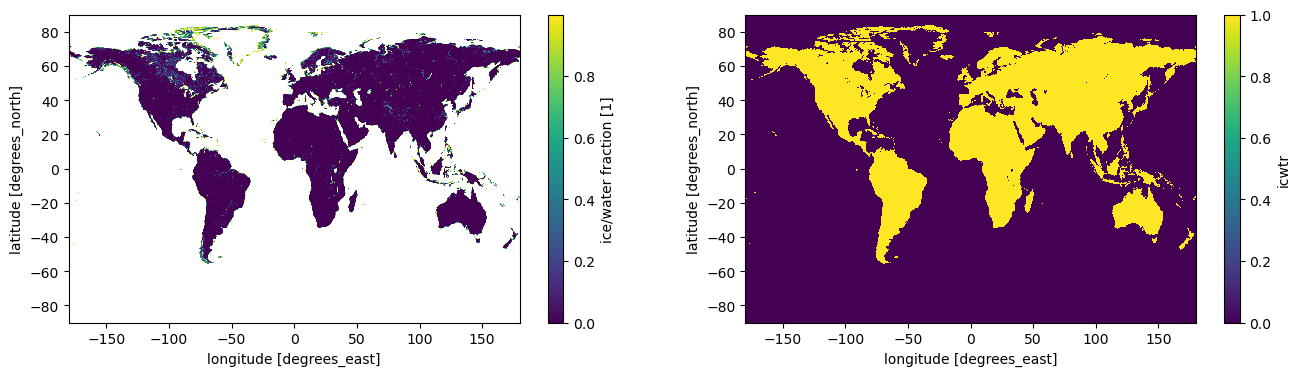

In [27]:
fig, axs = plt.subplots(ncols=2,figsize=(16,4))
static_mask_test_where.plot(ax=axs[0])
static_mask_test.plot(ax=axs[1])

# Calculate land fraction and mask to normalize against

In [28]:
ds_luh2_static["landfrac"] = 1 - ds_luh2_static.icwtr

In [29]:
ds_luh2 = SetMaskLUH2(ds_luh2, ds_luh2_static)
ds_luh2_static = SetMaskLUH2(ds_luh2_static,ds_luh2_static)
ds_regrid_target = SetMaskSurfData(ds_regrid_target)

# Regrid

In [30]:
regrid_luh2, regridder_luh2 = RegridConservative(ds_luh2, ds_regrid_target)


Defining regridder


/home/glemieux/local/conda/miniconda3/envs/jupyter-luh2/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')



Regridding
skipping variable 1/22: time
skipping variable 2/22: lat
skipping variable 3/22: lon
regridding variable 4/22: primf
regridding variable 5/22: primn
regridding variable 6/22: secdf
regridding variable 7/22: secdn
regridding variable 8/22: urban
regridding variable 9/22: c3ann
regridding variable 10/22: c4ann
regridding variable 11/22: c3per
regridding variable 12/22: c4per
regridding variable 13/22: c3nfx
regridding variable 14/22: pastr
regridding variable 15/22: range
regridding variable 16/22: secmb
regridding variable 17/22: secma
skipping variable 18/22: lat_bounds
skipping variable 19/22: lon_bounds
skipping variable 20/22: lat_b
skipping variable 21/22: lon_b


In [64]:
regrid_land_fraction = regridder_luh2(ds_luh2_static)

In [153]:
regrid_luh2_landfrac = regrid_luh2 / regrid_land_fraction.landfrac

# Sum the states

In [198]:
# Avoid summing non-vegetated variables
# coords_avoid = ["time","lat","lat_b","lon","lon_b","secma","secmb","urban"]
coords_avoid = ["time","lat","lat_b","lon","lon_b","secma","secmb"]
ds_varnames = list(regrid_luh2.variables.keys())
state_sum = 0.0
state_sum_landfrac = 0.0
for i in range(len(regrid_luh2.variables)):
    if (not(ds_varnames[i] in coords_avoid)):
        state_sum = state_sum + regrid_luh2[ds_varnames[i]]
        state_sum_landfrac = state_sum_landfrac + regrid_luh2_landfrac[ds_varnames[i]]
        # state_sum = state_sum + regrid_luh2[ds_varnames[i]].isel(time=0)
        # state_sum_landfrac = state_sum_landfrac + regrid_luh2_landfrac[ds_varnames[i]].isel(time=0)

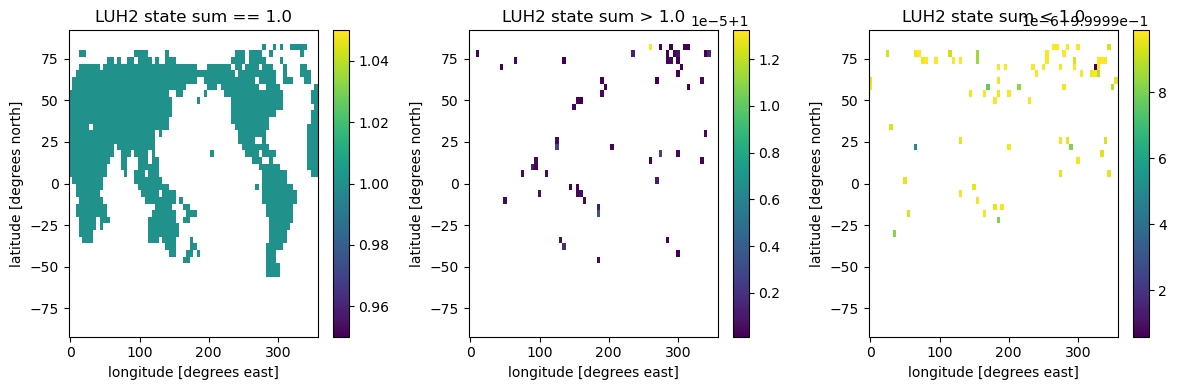

In [208]:
fig, axs = plt.subplots(ncols=3,figsize=(12,4))
state_sum_landfrac.where(state_sum_landfrac.mean(dim='time') == 1.0).mean(dim='time').plot(ax=axs[0])
axs[0].set_title('LUH2 state sum == 1.0')
state_sum_landfrac.where(state_sum_landfrac.mean(dim='time') > 1.0).mean(dim='time').plot(ax=axs[1])
axs[1].set_title('LUH2 state sum > 1.0')
state_sum_landfrac.where(state_sum_landfrac.mean(dim='time') < 1.0).mean(dim='time').plot(ax=axs[2])
axs[2].set_title('LUH2 state sum < 1.0')
fig.tight_layout()
# fig.suptitle('time = 0850-01-01')

In [169]:
state_sum_landfrac.isel(time=0).count()

<xarray.DataArray ()>
array(1161)
Coordinates:
    time     object 0850-01-01 00:00:00

In [161]:
state_sum_landfrac.isel(time=0).sum() / state_sum_landfrac.isel(time=0).count()

<xarray.DataArray ()>
array(0.99996804)
Coordinates:
    time     object 0850-01-01 00:00:00

## Alternate summation method to check against

In [195]:
regrid_luh2_landfrac_array = regrid_luh2_landfrac.to_array().isel(variable=slice(0,12))

In [196]:
state_sum_array = regrid_luh2_landfrac_array.sum(dim='variable')

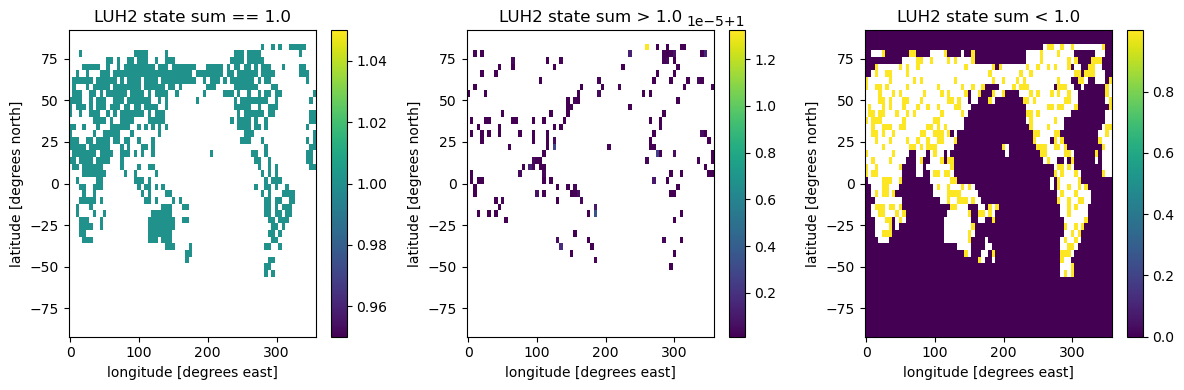

In [197]:
fig, axs = plt.subplots(ncols=3,figsize=(12,4))
state_sum_array.where(state_sum_array == 1.0).isel(time=0).plot(ax=axs[0])
axs[0].set_title('LUH2 state sum == 1.0')
state_sum_array.where(state_sum_array > 1.0).isel(time=0).plot(ax=axs[1])
axs[1].set_title('LUH2 state sum > 1.0')
state_sum_array.where(state_sum_array < 1.0).isel(time=0).plot(ax=axs[2])
axs[2].set_title('LUH2 state sum < 1.0')
fig.tight_layout()
# fig.suptitle('time = 0850-01-01')

In [174]:
state_sum_array.isel(time=0).sum() / state_sum_array.isel(time=0).where(state_sum_array.isel(time=0) != 0).count()

<xarray.DataArray ()>
array(0.99996804)
Coordinates:
    time     object 0850-01-01 00:00:00

**Temporary fix: normalize the states to unity and record the value to apply to transitions**

In [235]:
a = np.array([[0.8, 0.6, 0.3],[0.21, 0.39, 0.7]])
(a / a.sum(axis=0)).sum(axis=0)

array([1., 1., 1.])

In [218]:
corrb = 1.0 / a.sum(axis=0)


array([1., 1., 1.])

In [201]:
# regrid_luh2_landfrac["tcorr"] = 1.0 / state_sum_array
regrid_luh2_landfrac["tcorr"] = 1.0 / state_sum_landfrac

In [233]:
(regrid_luh2_landfrac / state_sum_landfrac).drop_vars({"secma","secmb","tcorr"}).to_array().sum(dim='variable').mean(dim='time').where(

<xarray.DataArray (lat: 46, lon: 72)>
array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 1.0000006, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)
Coordinates:
  * lon      (lon) float64 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0
  * lat      (lat) float64 -90.0 -86.0 -82.0 -78.0 -74.0 ... 78.0 82.0 86.0 90.0

In [191]:
checksum = (regrid_luh2_landfrac_array.isel(time=0) * regrid_luh2_landfrac.tcorr.isel(time=0)).sum(dim='variable')
checksum.sum() / checksum.where(checksum != 0).count() == 1.0

<xarray.DataArray ()>
array(True)
Coordinates:
    time     object 0850-01-01 00:00:00

In [202]:
# regrid_luh2_landfrac["tcorr"] = 1.0 / state_sum_landfrac
for i in range(len(regrid_luh2.variables)):
    if (not(ds_varnames[i] in coords_avoid)):
        regrid_luh2_landfrac[ds_varnames[i]] = regrid_luh2_landfrac[ds_varnames[i]] * regrid_luh2_landfrac["tcorr"]

In [204]:
new_state_sum = 0.0
new_state_sum_landfrac = 0.0
for i in range(len(regrid_luh2.variables)):
    if (not(ds_varnames[i] in coords_avoid)):
        new_state_sum = new_state_sum + regrid_luh2[ds_varnames[i]]
        new_state_sum_landfrac = new_state_sum_landfrac + regrid_luh2_landfrac[ds_varnames[i]]

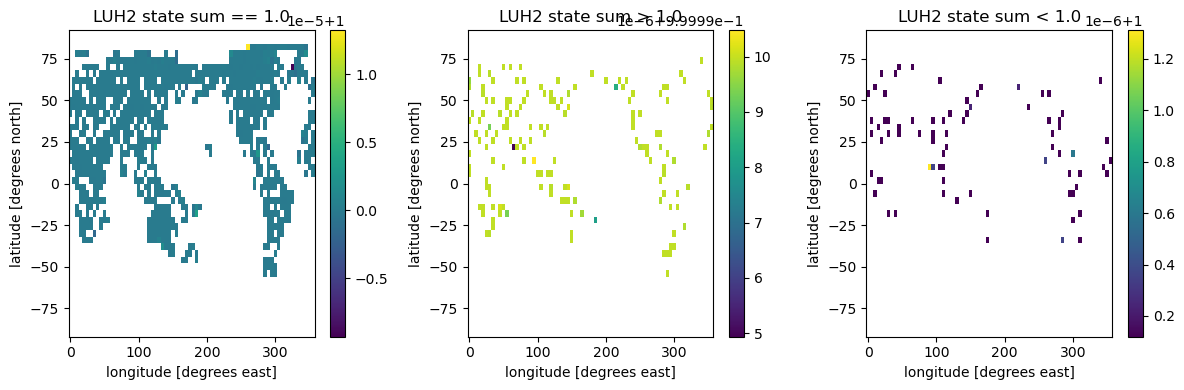

In [205]:
fig, axs = plt.subplots(ncols=3,figsize=(12,4))
state_sum_landfrac.where(new_state_sum_landfrac == 1.0).isel(time=0).plot(ax=axs[0])
axs[0].set_title('LUH2 state sum == 1.0')
state_sum_landfrac.where(new_state_sum_landfrac > 1.0).isel(time=0).plot(ax=axs[1])
axs[1].set_title('LUH2 state sum > 1.0')
state_sum_landfrac.where(new_state_sum_landfrac < 1.0).isel(time=0).plot(ax=axs[2])
axs[2].set_title('LUH2 state sum < 1.0')
fig.tight_layout()

## Exploration below

In [85]:
state_sum_zeronans = state_sum.where(~np.isnan(state_sum),0)
state_sum_landfrac_zeronans = state_sum_landfrac.where(~np.isnan(state_sum_landfrac),0)

In [86]:
ds_varnames[0]

'primf'

In [87]:
regrid_luh2[ds_varnames[0]][0]

<xarray.DataArray 'primf' (lat: 46, lon: 72)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ...,  0., nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    time     object 0850-01-01 00:00:00
  * lon      (lon) float64 0.0 5.0 10.0 15.0 20.0 ... 340.0 345.0 350.0 355.0
  * lat      (lat) float64 -90.0 -86.0 -82.0 -78.0 -74.0 ... 78.0 82.0 86.0 90.0

In [17]:
maxstates = state_sum_zeronans.where(state_sum_zeronans == state_sum_zeronans.max(), drop=True)
maxstates_sum = maxstates.sum(dim='time')
maxstates_count = maxstates.count(dim='time')
# maxstates.sum(dim='time') / maxstates.count(dim='time') == 1.0

In [19]:
maxstates_sum / maxstates_count

<xarray.DataArray (lat: 11, lon: 13)>
array([[       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan, 1.00000012,
        1.00000012,        nan,        nan],
       [       nan,        nan,        nan,        nan, 1.00000012,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan],
       [       nan,        nan,        nan,        nan, 1.00000011,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan],
       [       nan,        nan,        nan,        nan, 1.0000001 ,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan, 1.00000007,        nan,        nan,        nan,
               nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan, 1.00000012,        nan,        nan,
               nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
        1.00000007,        nan,        nan,        nan,        nan,
               nan,        nan,        nan],
       [       nan, 1.00000007, 1.00000012, 1.00000008,        nan,
        1.00000009,        nan,        nan,        nan,        nan,
               nan, 1.00000007,        nan],
       [1.00000008,        nan,        nan,        nan,        nan,
        1.0000001 ,        nan, 1.00000008,        nan,        nan,
               nan, 1.00000016, 1.00000009],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan, 1.00000012],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan, 1.00000007,        nan,
               nan,        nan,        nan]])
Coordinates:
  * lon      (lon) float64 0.0 5.0 10.0 15.0 20.0 ... 120.0 125.0 350.0 355.0
  * lat      (lat) float64 -26.0 -18.0 -14.0 -10.0 2.0 ... 18.0 22.0 26.0 34.0

In [20]:
maxstates_landfrac = state_sum_landfrac_zeronans.where(state_sum_landfrac_zeronans == state_sum_landfrac_zeronans.max(), drop=True)
maxstates_landfrac_sum = maxstates_landfrac.sum()
maxstates_landfrac_count = maxstates_landfrac.count()

In [22]:
maxstates_landfrac

<xarray.DataArray (time: 1166, lat: 1, lon: 1)>
array([[[1.0000132]],

       [[1.0000132]],

       [[1.0000132]],

       ...,

       [[1.0000132]],

       [[1.0000132]],

       [[1.0000132]]], dtype=float32)
Coordinates:
  * time     (time) object 0850-01-01 00:00:00 ... 2015-01-01 00:00:00
  * lon      (lon) float64 260.0
  * lat      (lat) float64 82.0